In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
""
import sys
import os
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import time as time
sys.path.append('/nfs/pic.es/user/e/egonzale/ia_cal/IACorr')
from compute_IA_corr_from_data import compute_2p_corr
cosmology = FlatLambdaCDM(H0=100.0, Om0=0.319, Ob0=0.049, Tcmb0=2.725)


In [8]:
path = '/data/astro/scratch/egonzale/FS_wide_cats/'

In [9]:
lenses = pd.read_parquet(path+'FS2_lens_19571.parquet')
sources = pd.read_parquet(path+'FS2_sources_19572.parquet')

In [ ]:
'''
lenses 
SELECT `halo_id`, `ra_gal`, `dec_gal`, `ra_mag_gal`, `dec_mag_gal`, `true_redshift_gal`, `observed_redshift_gal` FROM fs2_mock_std_2_1_10b_phz_wise where `lm_halo` >14 and lm_halo < 14.5 and true_redshift_gal > 0.25 and true_redshift_gal < 0.35 and kind == 0
sources
SELECT `ra_gal`, `dec_gal`, `ra_mag_gal`, `dec_mag_gal`, `true_redshift_gal`, `observed_redshift_gal`, gamma1, gamma2 FROM fs2_mock_std_2_1_10b_phz_wise where `lm_halo` >14 and lm_halo < 14.5 and true_redshift_gal > 0.5 and true_redshift_gal < 0.8
'''

In [10]:
sources

,ra_gal,dec_gal,ra_mag_gal,dec_mag_gal,true_redshift_gal,observed_redshift_gal,gamma1,gamma2
0,229.476257,2.996521,229.468369,2.993731,0.516565,0.515547,-0.005178,-0.009831
1,229.101440,3.616219,229.092422,3.614582,0.518539,0.518481,0.001703,0.005263
2,228.941650,4.343185,228.936646,4.339224,0.515073,0.520599,0.005639,-0.005669
3,228.951767,4.372902,228.946884,4.368696,0.515284,0.517117,-0.000059,-0.001578
4,225.576538,4.221992,225.579742,4.215604,0.532277,0.531047,-0.003390,-0.002501
...,...,...,...,...,...,...,...,...
10503581,220.001755,9.576492,220.012024,9.573395,0.782083,0.792491,-0.004078,0.002490
10503582,219.746384,10.823242,219.757278,10.819694,0.786180,0.786544,-0.006373,-0.004257
10503583,219.496506,14.939133,219.498062,14.946248,0.784246,0.782211,0.007233,0.012594
10503584,219.492599,14.952271,219.494034,14.959308,0.784628,0.789711,0.006697,0.010686


In [11]:
col_names = ['ra_gal','dec_gal','r_com','gamma1','gamma2', 'weight']
ra,dec,dcom,e1,e2,w = col_names
redshift = 'true_redshift_gal'

In [12]:
len(lenses)

4436

In [12]:
lenses[w] = np.ones(len(lenses))

In [16]:
def d_com(z):
    return cosmology.comoving_distance(z).value

In [17]:
lenses[dcom] = cosmology.comoving_distance(lenses[redshift]).value

In [18]:
sources[dcom] = cosmology.comoving_distance(sources[redshift]).value

In [19]:
sources[w] = np.ones(len(sources))

### Configuration 

In [20]:
# parameters related with bins
nbins = 10 # number of radial bins
rmin = 0.2 # minimum value for rp (r in case of the quadrupole)
rmax = 10. # maximum value for rp (r in case of the quadrupole)


# Related to JK patches
NPatches = int(nbins**(3./2.))
print('Number of patches',NPatches)
# Other configuration parameters
ncores = 30 # Number of cores to run in parallel
slop = 0. # Resolution for treecorr
box = False # Indicates if the data corresponds to a box, otherwise it will assume a lightcone


Number of patches 31


In [22]:
config = {'col_names': col_names,
          'nbins': nbins,
          'rmin': rmin,
          'rmax': rmax,
          'NPatches': NPatches,
          'ncores': ncores,
          'slop': slop,
          'box': box,
         }

In [27]:
corr = compute_2p_corr(lenses,sources,lenses,lenses,config)

{'col_names': ['ra_gal', 'dec_gal', 'r_com', 'gamma1', 'gamma2', 'weight'], 'nbins': 10, 'rmin': 0.2, 'rmax': 10.0, 'NPatches': 31, 'ncores': 30, 'slop': 0.0, 'box': False, 'pi_max': 60.0, 'npi': 5, 'mubins': 10, 'grid_resolution': 10, 'exact_position': True, 'sky_threshold': 1.0}


In [37]:
corr.compute_delta_sigma()

In [31]:
import treecorr

In [32]:
        sd = treecorr.NGCorrelation(nbins=config['nbins'], 
                                    min_sep=config['rmin'], 
                                    max_sep=config['rmax'], 
                                    bin_slop=config['slop'], brute = False, 
                                    verbose=0, var_method = 'jackknife')


In [33]:
sd.process(corr.pcat, corr.scat, metric='Rperp', num_threads = config['ncores'])

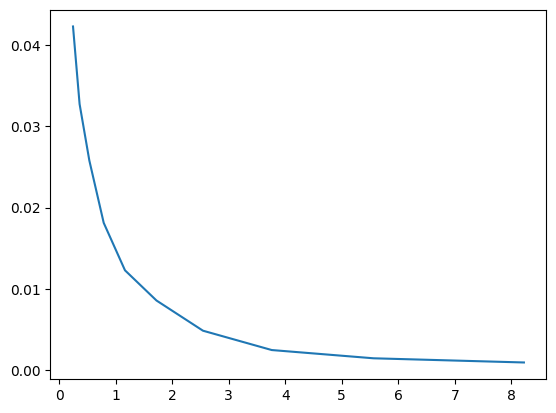

In [38]:
plt.plot(corr.gs.rp,corr.gs.xi)